This notebook runs MCMC for the model with two states and three parameters, fitting the value of alpha is effectively fitting the value of $r_M$ which, for this approximation, is unknown. 

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import emcee
import h5py
import tqdm
from multiprocessing import Pool
from EvolutionExperiment import EvolutionExperimentTwoStates


# First attempt to run MCMC for three parameters

In [12]:
np.random.seed(42)
test_p0 = np.array([0.001, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# From the experiments:
#   K:10^10, adjusting for the scale we're using, effctively 10^2
#   Bottleneck size (Dilution percentage): 1%

test_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 4.92599034e-09, 'mu_cf' : 1.22323591e-04, 'K' : 100}
model_experiment = EvolutionExperimentTwoStates('delserCGA', num_days , test_params, dilution_percentage = 0.01)
model_experiment.p0 = test_p0
model_experiment.p1 = test_p0

In [46]:
def log_prior(theta):
    '''
        I will use gaussian priors for both transition rates
        For mu_fc -> N(1e-9, 1e-7)
        For mu_cf -> N(1e-3, 1e-3)
        For alpha -> N(1e-3, 2e-2)
    '''
    alpha, mu_fc, mu_cf = theta
    if 0 < mu_fc and 0 < mu_cf :
        temp_gaussian = 0.5 * (0.4 * (alpha - 1.3) + 1e16 * (mu_fc - 1e-8) ** 2 + 1e6 * (mu_cf - 1e-3) ** 2)
        return -1.5 * np.log(2 * np.pi) + 12 * np.log(10) - np.log(2) - temp_gaussian
    return -np.inf

def log_likelihood(theta, x, y, df = 1):
    '''
        Since the fraction of small and large are not independent, it is sufficient with consider one of them when comparing
        with the experimental data
        Input:
            - theta: array with the parameters in order (alpha, mu_fc, mu_cf)
            - x: array with the days for which there are expeimental measurements
            - y: array with the experimental measurements
    '''
    alpha, mu_fc, mu_cf = theta
    model_experiment.run_experiment_for_inference(alpha, mu_fc, mu_cf)
    temp_diff = model_experiment.daily_fraction[x][:,0] - y
    return -0.5 * (np.sum(temp_diff**2 / df**2))

# ENCEE needs a lnprob function to put together prior and posterior (in log space)
def log_prob(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)


To calculate the likelihood I need to test only the points with the same day as the experiment,
solve the equation for 100 days and select only those with information in the experiment as well

In [47]:
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]


Define the parameters for MCMC, I will be using 500 walkers with 500 steps each

In [49]:
start = np.array([ test_params['r_c'] /  test_params['r_f'], test_params['mu_fc'], test_params['mu_cf']])
ndim, nwalkers, nsteps = start.shape[0], 100, 500
pos = [start + np.array([1e-3 * np.random.default_rng().standard_normal(), 1e-9 * np.random.default_rng().standard_normal(), 1e-4 * np.random.default_rng().standard_normal()]) for i in range(nwalkers)]

Plot the initial distribution of the walkers in the parameter space, the plot below is only for the mutation rates

Text(0, 0.5, '$mu_{fc}$')

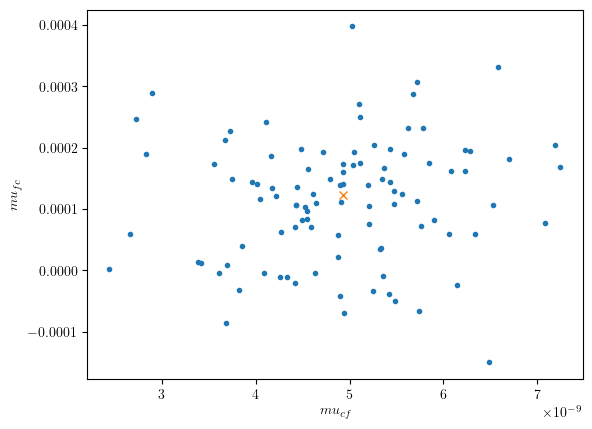

In [50]:
plt.plot(np.array(pos)[:,1], np.array(pos)[:,2], '.')
plt.plot(test_params['mu_fc'], test_params['mu_cf'], 'x')
plt.xlabel(r"$mu_{cf}$")
plt.ylabel(r"$mu_{fc}$")

In [51]:
x = temp_df.day.values
y = temp_df[['frac_small']].values

In [52]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "mcmc_evolution_experiment_3st_2param.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y), backend=backend)

In [53]:
max_n = 50000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps

with Pool() as pool:
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  0%|          | 0/50000 [00:00<?, ?it/s]/Users/miguel/anaconda3/envs/trna/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 16%|█▋        | 8200/50000 [25:12:22<128:29:24, 11.07s/it]


Let's visualize the chains 

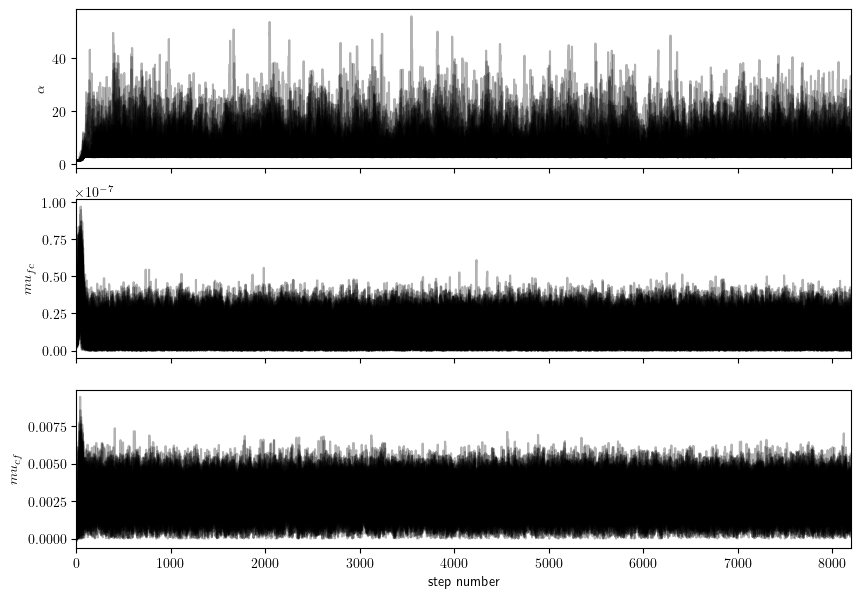

In [55]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\alpha$", r"$mu_{fc}$", r"$mu_{cf}$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Discard the first 100 steps and uses the autocorrelation time to sample

In [57]:
tau = sampler.get_autocorr_time()
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard = 100, thin = thin, flat = True)
print(flat_samples.shape)

(35200, 3)


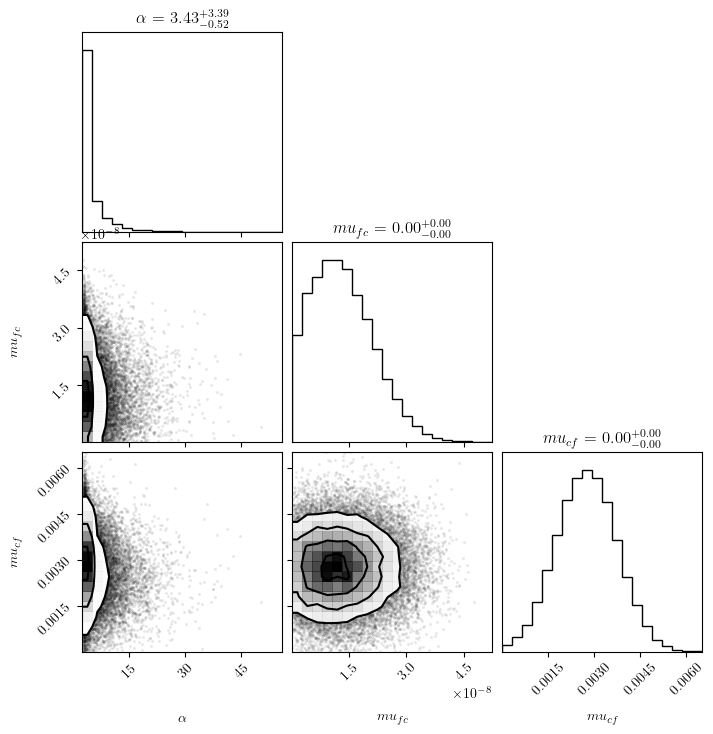

In [58]:
import corner

labels = labels = [r"$\alpha$", r"$mu_{fc}$", r"$mu_{cf}$"]
fig = corner.corner(
    flat_samples, labels=labels,
    show_titles = True
);

The title in the plots represent the median of the data with upper and lower bounds

emcee package uses an affine invariant algorithm to run the markov chain

In [60]:
np.median(flat_samples, axis = 0), np.mean(flat_samples, axis = 0) 

(array([3.42639529e+00, 1.25223626e-08, 2.76610510e-03]),
 array([4.85638937e+00, 1.33041159e-08, 2.76552885e-03]))

# MCMC with a narrower parameter space search

### Trying to speed up the calculations

In [61]:
from time import perf_counter
model = np.zeros(1000)
model2 = np.zeros(1000)
for i in range(1000):
    t1 = perf_counter()
    model_experiment.run_experiment()
    t2 = perf_counter()
    model[i] = t2 - t1

Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running th

In [70]:
for i in range(1000):
    t3 = perf_counter()
    model_experiment.run_experiment2()
    t4 = perf_counter()
    model2[i] = t4-t3

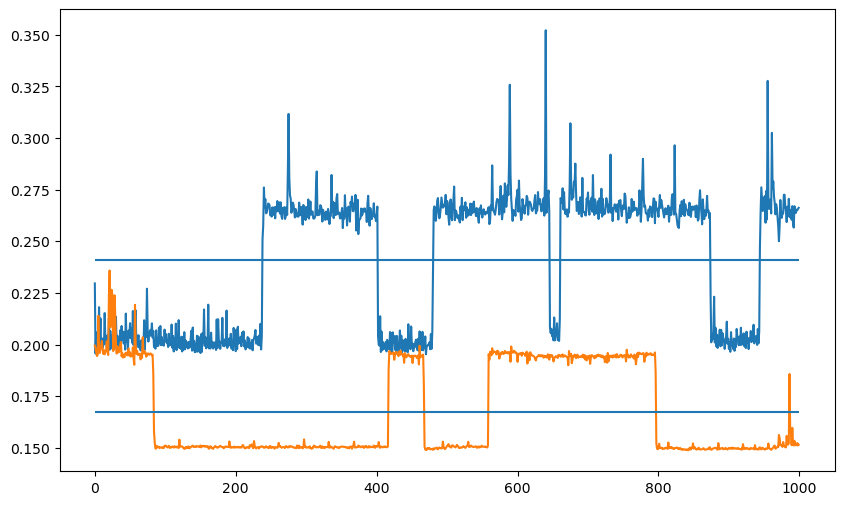

In [71]:
plt.figure(figsize = (10, 6))
plt.plot(model)
plt.plot(model2)
plt.hlines(xmin = 0, xmax = 1000, y = model.mean())
plt.hlines(xmin = 0, xmax = 1000, y = model2.mean())

In [74]:
model2_2 = np.zeros(1000)
for i in range(1000):
    t3 = perf_counter()
    model_experiment.run_experiment2()
    t4 = perf_counter()
    model2_2[i] = t4-t3

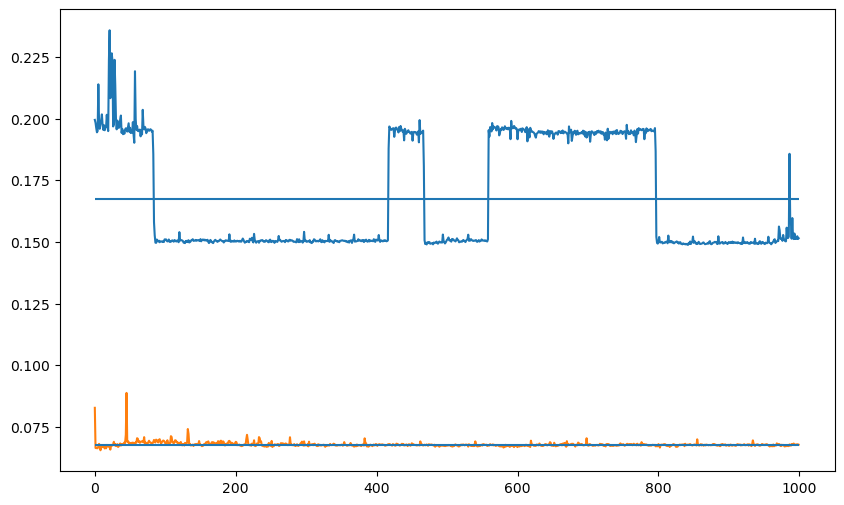

In [75]:
plt.figure(figsize = (10, 6))
plt.plot(model2)
plt.plot(model2_2)
plt.hlines(xmin = 0, xmax = 1000, y = model2.mean())
plt.hlines(xmin = 0, xmax = 1000, y = model2_2.mean())

### Running with the improved algorithm as found above

In [75]:
def log_prior(theta):
    '''
        I will use gaussian priors for both transition rates
        For mu_fc -> N(1e-9, 1e-7)
    '''
    alpha, mu_fc, mu_cf = theta
    if 0 < mu_fc and 0 < mu_cf :
        temp_gaussian = 0.5 * (0.04 * (alpha - 1.3) + 1e16 * (mu_fc - 1e-8) ** 2 + 1e6 * (mu_cf - 1e-3) ** 2)
        return -1.5 * np.log(2 * np.pi) + 12 * np.log(10) - np.log(2) - temp_gaussian
    return -np.inf

def log_likelihood(theta, x, y, df = 1):
    '''
        If the data have gaussian error, they will follow a chi-squared distribution with the number of degrees of freedom
        equal to number of samples - number parameters
        Since the fraction of small and large are not independent, it is sufficient with consider one of them when comparing
        with the experimental data
        Input:
            - theta: array with the parameters in order (alpha, mu_fc, mu_cf)
            - x: array with the days for which there are expeimental measurements
            - y: array with the experimental measurements
    '''
    alpha, mu_fc, mu_cf = theta
    model_experiment.run_experiment_for_inference(alpha, mu_fc, mu_cf)
    temp_diff = model_experiment.daily_fraction[x][:,0] - y
    return -0.5 * (np.sum(temp_diff**2 / df**2))

# ENCEE needs a lnprob function to put together prior and posterior (in log space)
def log_prob(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)


In [76]:
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[(df.founder=='delserCGA') & (df.replicate == 1)]

In [77]:
start = np.array([ test_params['r_c'] /  test_params['r_f'], test_params['mu_fc'], test_params['mu_cf']])
ndim, nwalkers, nsteps = start.shape[0], 100, 500
pos = [start + np.array([1e-3 * np.random.default_rng().standard_normal(), 1e-9 * np.random.default_rng().standard_normal(), 1e-4 * np.random.default_rng().standard_normal()]) for i in range(nwalkers)]

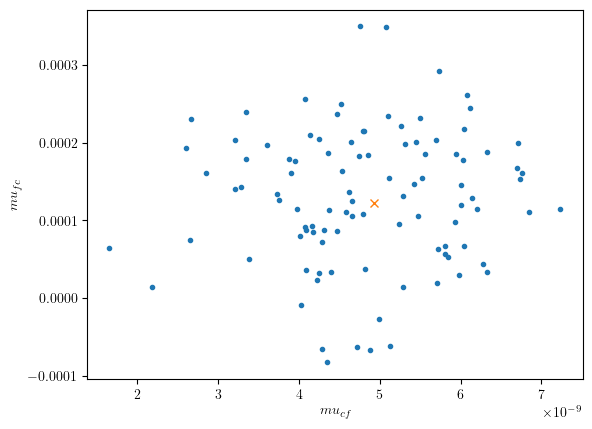

In [78]:
plt.plot(np.array(pos)[:,1], np.array(pos)[:,2], '.')
plt.plot(test_params['mu_fc'], test_params['mu_cf'], 'x')
#plt.plot(test_params['r_c'], test_params['mu_cf'], 'x')
plt.xlabel(r"$mu_{cf}$");
plt.ylabel(r"$mu_{fc}$");
plt.show()

In [79]:
x = temp_df.day.values
y = temp_df[['frac_small']].values

In [80]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "mcmc_evolution_experiment_3st_2param_attempt2.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y), backend=backend)

In [81]:
max_n = 50000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps

with Pool() as pool:
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  0%|          | 0/50000 [00:00<?, ?it/s]/Users/miguel/anaconda3/envs/trna/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 15%|█▌        | 7600/50000 [26:56:57<150:20:52, 12.77s/it]


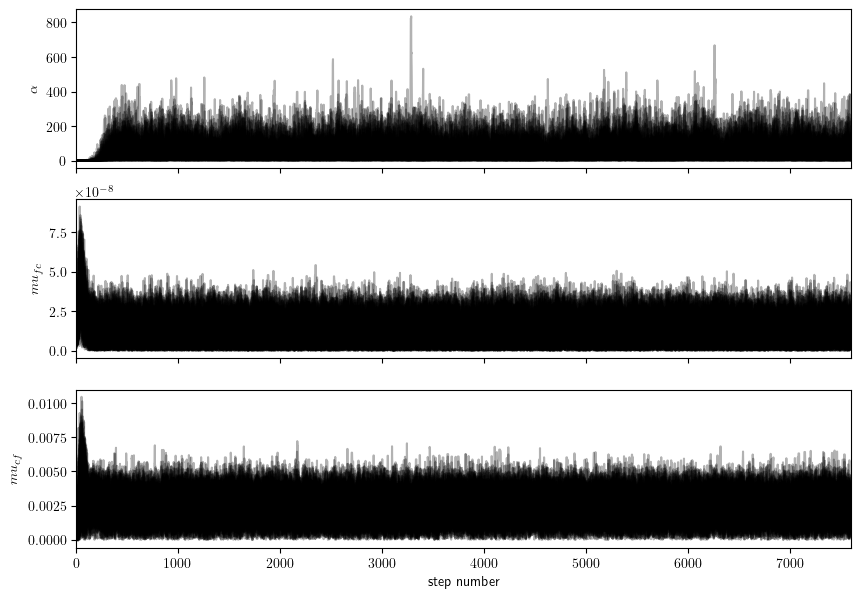

In [82]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\alpha$", r"$mu_{fc}$", r"$mu_{cf}$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

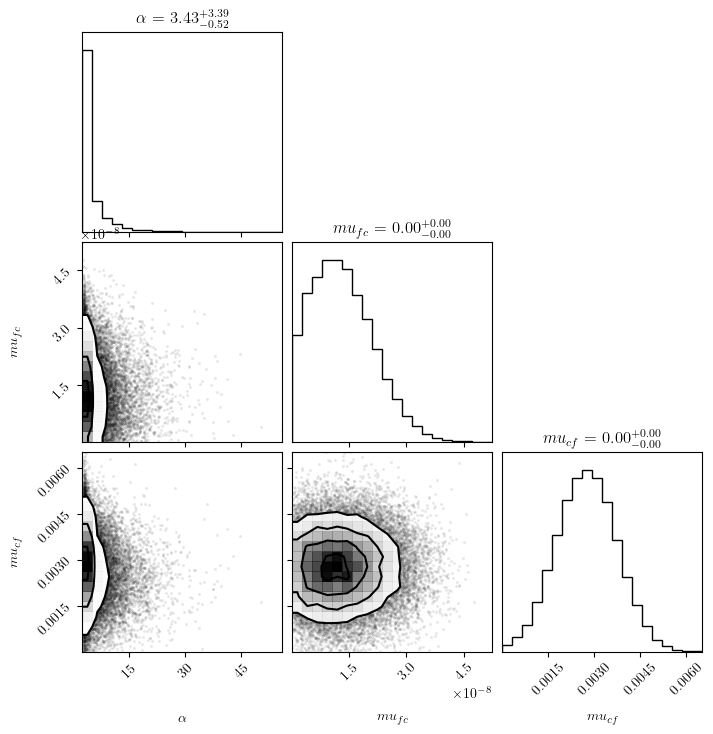

In [83]:
labels = labels = [r"$\alpha$", r"$mu_{fc}$", r"$mu_{cf}$"]
fig = corner.corner(
    flat_samples, labels=labels,
    show_titles = True
);

In [84]:
np.median(flat_samples, axis = 0), np.mean(flat_samples, axis = 0) 

(array([3.42639529e+00, 1.25223626e-08, 2.76610510e-03]),
 array([4.85638937e+00, 1.33041159e-08, 2.76552885e-03]))

In [ ]:
(array([3.42639529e+00, 1.25223626e-08, 2.76610510e-03]),
 array([4.85638937e+00, 1.33041159e-08, 2.76552885e-03]))

In [86]:
flat_samples.shape

(35200, 3)

In [88]:
print(model_experiment)

strain_name : delserCGA 
parameters (r_f : 0.0406, mu_fc : 3.812655171837585e-08, r_c : 0.05448, mu_cf : 0.004192714554279169, K : 100) 
                 


<Axes: title={'center': 'delserCGA'}, xlabel='Day', ylabel='Population fraction'>

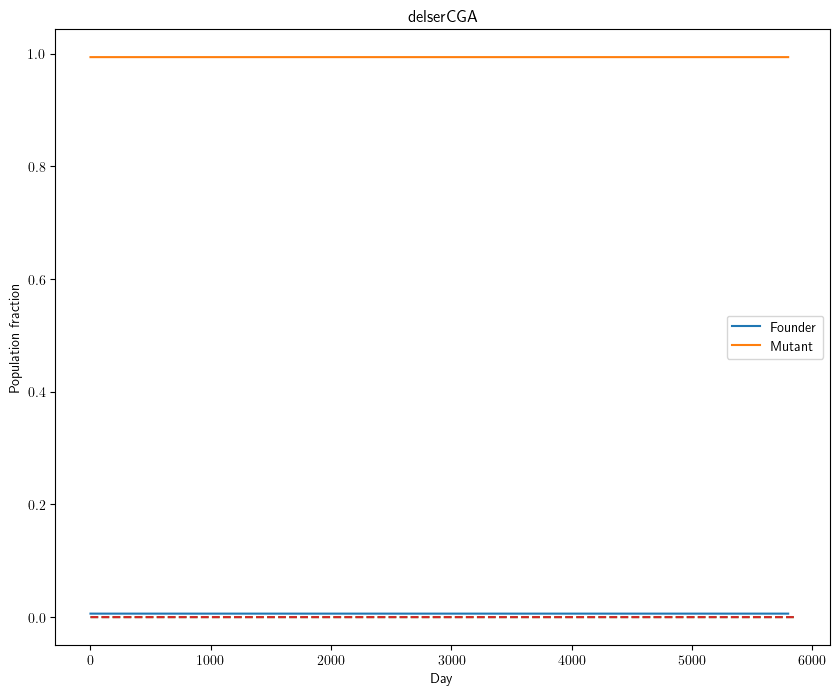

In [89]:
model_experiment.plot_evolution_frac()

In [90]:
test_p0 = np.array([1, 0])
num_days = 101
# When using delserCGA the replication rate of the founder is found using the growth curve fits
# Additionally, the replication rate of the mutant is assumed to be the rate of M2lop obtained with the gc fit
# The number of days in the experiment is 100, for testing let's assume 10
# M2lop replication rate : 0.05447838370459147
# delserCGA replication rate : 0.04060341705556068
# From the experiments:
#   K:10^10, adjusting for the scale we're using, effctively 10^2
#   Bottleneck size (Dilution percentage): 1%

test_params = {'r_f' : 0.04060, 'r_c' : 0.05448, 'mu_fc' : 4.92599034e-09, 'mu_cf' : 1.22323591e-04, 'K' : 100}
test_model = EvolutionExperimentTwoStates('delserCGA', num_days , test_params, dilution_percentage = 0.01)
test_model.p0 = test_p0
test_model.p1 = test_p0

In [91]:
test_model.run_experiment()

Running the evolution experiment


Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running the evolution experiment
Running th

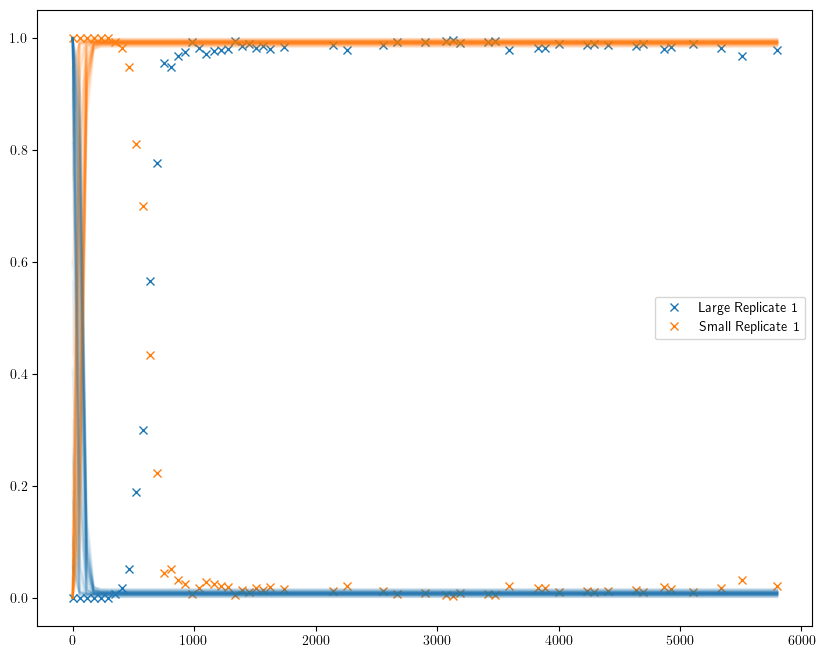

In [123]:
temp_flat = flat_samples[flat_samples[:,2] < 1.5]
inds = np.random.randint(len(temp_flat), size=100)
fig, ax = plt.subplots(figsize = (10, 8))
days = np.arange(test_model.number_days) * test_model.time_interval.shape[0]
#founder_line = ax.plot(days, test_model.daily_fraction[:, 0], label = 'Founder')
#mutant_line = ax.plot(days, test_model.daily_fraction[:, 1], label = 'Mutant')
#ax = test_model.plot_evolution_frac()
df = pd.read_csv('/Users/miguel/Documents/Internship_CENTURI/data/plate_counts.csv')
df = df.sort_values(['founder', 'replicate']).reset_index(drop=True)
temp_df = df[df.founder=='delserCGA']

for i in temp_df.replicate.unique()[:1]:
    temp_df = temp_df[temp_df.replicate == i]
    ax.plot(temp_df.day.values * model_experiment.time_interval.shape[0], temp_df.frac_large, 'x', label = f'Large Replicate {i}')
    ax.plot(temp_df.day.values * model_experiment.time_interval.shape[0], temp_df.frac_small, 'x', label = f'Small Replicate {i}')
for ind in inds:
    sample = temp_flat[ind]
    temp_model = EvolutionExperimentTwoStates('delserCGA', num_days, {'r_f' : 0.04060, 'r_c' : 0.05448}, dilution_percentage= 0.01)
    temp_model.p0 = test_p0
    temp_model.alpha, temp_model.mu_fc, temp_model.mu_cf = sample
    temp_model.run_experiment()
    days = np.arange(temp_model.number_days) * temp_model.time_interval.shape[0]
    ax.plot(days, temp_model.daily_fraction[:, 0], 'C0', alpha = 0.05)
    ax.plot(days, temp_model.daily_fraction[:, 1], 'C1', alpha = 0.05 )
ax.legend()

In [117]:
flat_samples[flat_samples[:,0]<1.5]

array([], shape=(0, 3), dtype=float64)

In [131]:
valid_cases = []
for i1 in range(1,3):
    for i2 in range(1,4):
        for i3 in range(1,3):
            for i4 in range(1,4):
                print(i1,i2,i3,i4)
                if i1 == i2 or i3 == i4:
                    print(True)
                    continue
                case = str(i1) + str(i2) + str(i3) + str(i4)
                valid_cases.append(case)

1 1 1 1
True
1 1 1 2
True
1 1 1 3
True
1 1 2 1
True
1 1 2 2
True
1 1 2 3
True
1 2 1 1
True
1 2 1 2
1 2 1 3
1 2 2 1
1 2 2 2
True
1 2 2 3
1 3 1 1
True
1 3 1 2
1 3 1 3
1 3 2 1
1 3 2 2
True
1 3 2 3
2 1 1 1
True
2 1 1 2
2 1 1 3
2 1 2 1
2 1 2 2
True
2 1 2 3
2 2 1 1
True
2 2 1 2
True
2 2 1 3
True
2 2 2 1
True
2 2 2 2
True
2 2 2 3
True
2 3 1 1
True
2 3 1 2
2 3 1 3
2 3 2 1
2 3 2 2
True
2 3 2 3


In [135]:
valid_cases

['1212',
 '1213',
 '1221',
 '1223',
 '1312',
 '1313',
 '1321',
 '1323',
 '2112',
 '2113',
 '2121',
 '2123',
 '2312',
 '2313',
 '2321',
 '2323']

In [136]:
len(valid_cases)

16

In [145]:
eqs_valid = {}
eq1 = {'1' : 'F', '2' : 'M'}
eq2 = {'1' : 'F^2', '2' : 'M^2', '3' : 'MF'}
for i in valid_cases:
    temp_str = eq1[i[0]] + ", " + eq2[i[1]] + ", " + eq1[i[2]] + ", " + eq2[i[3]]
    eqs_valid[i] = temp_str



In [146]:
eqs_valid

{'1212': 'F, M^2, F, M^2',
 '1213': 'F, M^2, F, MF',
 '1221': 'F, M^2, M, F^2',
 '1223': 'F, M^2, M, MF',
 '1312': 'F, MF, F, M^2',
 '1313': 'F, MF, F, MF',
 '1321': 'F, MF, M, F^2',
 '1323': 'F, MF, M, MF',
 '2112': 'M, F^2, F, M^2',
 '2113': 'M, F^2, F, MF',
 '2121': 'M, F^2, M, F^2',
 '2123': 'M, F^2, M, MF',
 '2312': 'M, MF, F, M^2',
 '2313': 'M, MF, F, MF',
 '2321': 'M, MF, M, F^2',
 '2323': 'M, MF, M, MF'}